In [32]:
import os
import shutil

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pytorch_lightning as pl
import requests
import torch
from albumentations.pytorch import ToTensorV2

from utils import OxfordIIITPetDataModule

In [2]:
model_uri = 'runs:/db6f23fc1c4543c79b03e1d7da0f372d/model'

In [3]:
model = mlflow.pytorch.load_model(model_uri)

In [5]:
test_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [7]:
data_dir = os.getcwd()
datamodule = OxfordIIITPetDataModule(
    data_dir=data_dir,
    batch_size=1,
    test_transforms=test_transform,
    download=True,
    num_workers=4
)
trainer = pl.Trainer(
    logger=False,
    gpus=1 if torch.cuda.is_available() else None,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [8]:
trainer.test(model, datamodule, verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 3669/3669 [09:55<00:00,  6.16it/s]


[{'test_dice': 0.932266116142273, 'test_iou': 0.8833593726158142}]

In [9]:
def download_img(img_url, filename):
    r = requests.get(img_url, stream=True)
    if r.status_code == 200:
        r.raw.decode_content = True
        with open(filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

        return True

    else:
        return False

In [21]:
img_url = "https://www.alouetteanimalhospital.ca/wp-content/uploads/sites/308/2022/06/pettips.jpg"
filename = "img.jpg"

In [22]:
download_img(img_url, filename)

True

In [23]:
image = cv2.imread('img.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [24]:
image_tensor = test_transform(image=image_rgb)["image"]
image_batch = image_tensor.unsqueeze(0)

In [25]:
model.eval();

In [26]:
with torch.no_grad():
    out = model(image_batch)["out"]

In [27]:
predicted_mask = torch.round(out.sigmoid().squeeze()).cpu().data.numpy()
predicted_mask = A.CenterCrop(image.shape[0], image.shape[1], always_apply=True)(image=predicted_mask)["image"]

In [28]:
out_array_rgb = np.stack([np.zeros_like(predicted_mask), np.zeros_like(predicted_mask), predicted_mask], axis=2)

In [29]:
alpha = 0.95

In [30]:
combined_image = (alpha * out_array_rgb + image_rgb / 255).clip(0, 1)

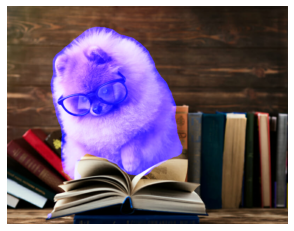

In [31]:
plt.imshow(combined_image)
plt.axis("off")
plt.show()